<a href="https://colab.research.google.com/github/Maagnitude/CRC_slides_models/blob/main/CRC_slides_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **2η Εργασία** στο μάθημα **Μηχανική Μάθηση και Εφαρμογές**

# **Τμήμα Πληροφορικής και Τηλεματικής - Χαροκόπειο Πανεπιστήμιο**

# **Καζάζης Γεώργιος - it214124**

Στην παρούσα εργασία θα αναπτύξουμε **μοντέλα Συνελικτικών Νευρωνικών Δικτύων**, για να κατηγοριοποιήσουμε όσο πιο σωστά γίνεται τις 7180 εικόνες μικροσκοπίου, στις 9 κλάσεις που έχουμε.

**Αρχίζοντας...**

# **Βιβλιοθήκες**
Κάνουμε import τα απαραίτητα **modules**. 
*   Την **pandas** και την **numpy** για την διαχείρηση των δεδομένων μας.

*  Την **matplotlib.pyplot** και την **seaborn** για την οπτικοποίηση των δεδομένων μας. **Ιστογράμματα**, **boxplots** κλπ.

*  Την **missingno** ώστε να οπτικοποιήσουμε το αν υπάρχουν ελλιπείς εγγραφές.

*   Από την **sklearn** κάνουμε import:
      *   Την **linear_model** για να εκπαιδεύσουμε το **Logistic Regression model**.
      *   Την **neural_network** για να υλοποιήσουμε και να εκπαιδεύσουμε ΤΝΔ.
      *  Την **StardardScaler** και την **train_test_split** για το **Preprocessing** κομμάτι. Συγκεκριμένα για την τυποποίηση των δεδομένων και για να χωρίσουμε τα δεδομένα μας σε **test data** και **train data**.
      *  Την **metrics** για τις μετρικές που θα χρησιμοποιήσουμε, όπως η **confusion_matrix**.
      *  Την **RandomForestClassifier** για να εκπαιδεύσουμε ένα Random Forest model.
*  Το **tensorflow**, και από αυτό, τα **keras** και **layers** για την ανάπτυξη νευρωνικών δικτύων.

*  Τέλος, κάνουμε import τα **warnings** και τα φιλτράρουμε, ώστε να μην εμφανίζονται.


In [118]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers
import keras.datasets
from keras.callbacks import EarlyStopping
from keras.layers import Rescaling
from keras.layers import MaxPooling2D

## **drive mount και μεταφόρτωση των εικόνων**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp '/content/drive/MyDrive/Colab Notebooks/CRC_slides.tar.gz' .
!tar -xvzf 'CRC_slides.tar.gz'
data_dir = '/content/CRC_slides'

# **Υλοποίηση συνάρτησης για την δημιουργία των datasets**
Περνάμε τα αρχεία του φακέλου **data_dir** στην μεταβλητή **all_ds** και ύστερα τα χωρίζουμε σε **training**, **validation** και **test sets**. Το πετυχαίνουμε με την χρήση των συναρτήσεων **next** και **skip**, όπου παίρνουμε τον αριθμό των αρχείων που αντιστοιχεί στο **devel_ds** (**next**), ύστερα τα κάνουμε **skip**, ώστε να πάρουμε τα επόμενα για το **train_ds** κτλ.

Σχετικά με τις παραμέτρους: 
* **data_dir** είναι ο φάκελος που βρίσκονται τα αρχεία.
* **labels='inferred'** για να παράξει τα labels από τους υποφακέλους.
* **label_moded='int'** που συμαίνει ότι τα labels είναι κωδικοποιημένα ως integers.
* **class_names**=None για να χρησιμοποιηθεί αλφαριθμητικη σειρά, μιας και δεν μας νοιάζει.
* **color_mode='rgb'** για να έχουν 3 κανάλια οι εικόνες.
* **batch_size** βάζουμε το batch size που μας δίνει η εκφώνηση. Πόσες εικόνες θα πάρει μαζί. Το default θα ήταν 32.
* **image_size** βάζουμε το size που μας δίνει η εκφώνηση. Αν βάλουμε άλλο αριθμό απ αυτόν που είναι η εικόνες, γίνεται resize.
* **shuffle=True** που είναι και η default τιμή, απλά το βάζουμε να φαίνεται. Αν ήταν False θα έκανε sort τα δεδομένα σε αλφαριθμητική σειρά.
* **seed=123** ???

In [129]:
def load_dataset(data_dir, train_pct=0.6, val_pct=0.2, test_pct=0.2, batch_size=64, img_size=(224, 224)):

  # Βάζουμε τα όλα δεδομένα στην μεταβλητή all_ds
  all_ds = keras.utils.image_dataset_from_directory(data_dir, labels='inferred', label_mode='int', class_names=None, 
                              color_mode='rgb', batch_size=batch_size, image_size=img_size, shuffle=True, seed=123)

  # Χωρίζουμε τα δεδομένα μας σε training, validation και test sets
  # Παίρνουμε το σύνολο των δειγμάτων
  num_samples = len(all_ds)
  
  # Παίρνουμε το μέγεθος του κάθε set βάσει του ποσοστού που γνωρίζουμε
  train_size = int(train_pct * num_samples)
  val_size = int(val_pct * num_samples)
  test_size = int(test_pct * num_samples)
  devel_size = num_samples - train_size - val_size - test_size

  # Ανάλογα με το size του κάθε set, το γεμίζουμε με τα δεδομένα της all_ds
  devel_ds = all_ds.take(devel_size)
  train_ds = all_ds.skip(devel_size).take(train_size)
  val_ds = all_ds.skip(devel_size + train_size).take(val_size)
  test_ds = all_ds.skip(devel_size + train_size + val_size).take(test_size)

  # Παίρνουμε τις κατηγορίες των δεδομένων
  classes = all_ds.class_names

  return devel_ds, train_ds, val_ds, test_ds, classes

In [130]:
devel_ds, train_ds, val_ds, test_ds, classes = load_dataset(data_dir)

Found 7180 files belonging to 9 classes.


## **Για να δούμε τις πρώτες 9 εικόνες του train_ds**

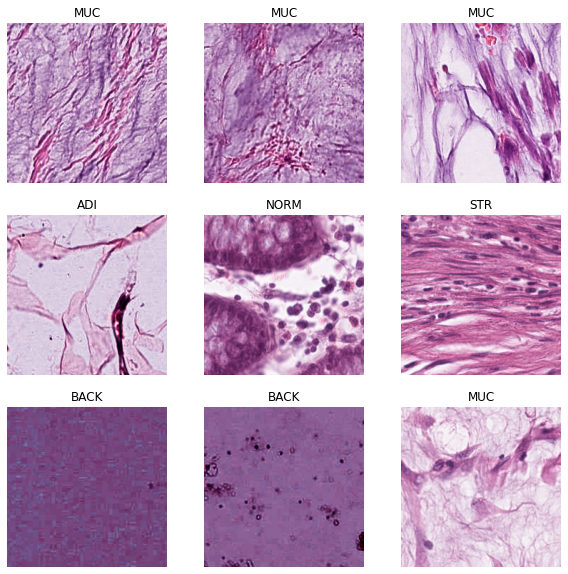

In [89]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

In [125]:
images_ds = tf.data.Dataset.list_files(data_dir+"/*/*", shuffle=False)

for image in images_ds.take(1):
  print(image.numpy())

b'/content/CRC_slides/ADI/ADI-TCGA-AAICEQFN.png'


In [141]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 224, 224, 3)
(64,)


In [144]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy().shape)

Image shape:  (64, 224, 224, 3)
Label:  (64,)


In [11]:
num_classes= len(classes)

## **Παρακάτω οπτικοποιούμε τον αριθμό των αρχείων κάθε κατηγορίας στο σύνολο ανάπτυξης**.

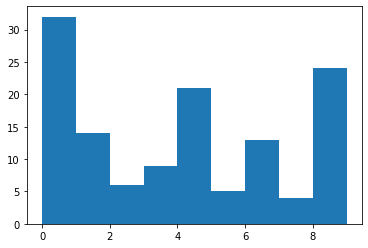

In [6]:
y = np.concatenate([y for x, y in devel_ds])
plt.hist(y, list(range(len(classes) + 1)))
plt.show()

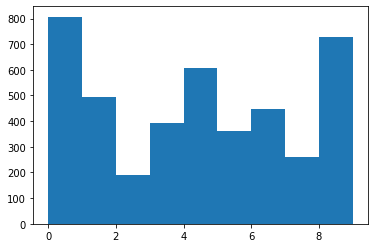

In [7]:
y = np.concatenate([y for x, y in train_ds])
plt.hist(y, list(range(len(classes) + 1)))
plt.show()

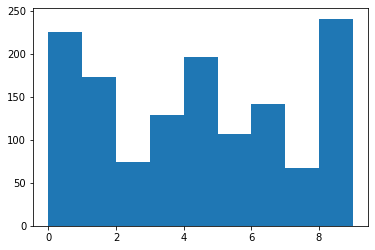

In [8]:
y = np.concatenate([y for x, y in test_ds])
plt.hist(y, list(range(len(classes) + 1)))
plt.show()

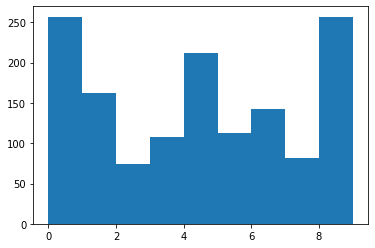

In [9]:
y = np.concatenate([y for x, y in val_ds])
plt.hist(y, list(range(len(classes) + 1)))
plt.show()

# **Υλοποίηση συνάρτησης για την δημιουργία συνελικτικού νευρωνικού δικτύου**.

Στο **πρώτο layer** κάνουμε rescaling τις τιμές των εικόνων (pixel values) από **[0, 255]** σε **[0, 1]**


In [147]:
def cnn1(num_classes):

  #
  model = keras.Sequential([
      keras.Input(shape=(224, 224, 3)),
      layers.Rescaling(1./255),
      layers.Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Flatten(),
      layers.Dense(32, activation='relu'),
      layers.Dense(num_classes, activation='softmax')
  ])

  return model

In [148]:
model = cnn1(num_classes)

model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(train_ds, validation_data=val_ds, batch_size=64, epochs=5)
score = model.evaluate(val_ds)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_13 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 224, 224, 8)       224       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 112, 112, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 112, 112, 16)      1168      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 56, 56, 16)       0         
 g2D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 50176)           

In [149]:
def confusion_matrix(model, test_ds):
    y_test = []
    y_pred = []
    for x_1, y_1 in test_ds:
        y_pred_1 = model.predict(x_1)
        y_test.append(y_1)
        y_pred.append(y_pred_1)
        y_true = np.concatenate(y_test)
        y_p = np.concatenate(y_pred)
        y_hat = tf.argmax(y_p, axis=1)
        cm = tf.math.confusion_matrix(y_true, y_hat)
    return cm, y_hat

In [151]:
cm, y_hat = confusion_matrix(model, test_ds)

1/1 [==============================] - 0s 210ms/step


In [154]:
import pandas as pd
import seaborn as sns

In [159]:
def heat_confmatrix (cm):
  
  labels = classes

  # Δίνουμε τα labels στον πίνακα
  cm_plt = pd.DataFrame(cm, index = labels, columns = labels)
  
  plt.subplots(figsize=(9, 7))
  
  ax = sns.heatmap(cm_plt, cmap='viridis', annot=True, annot_kws={'size':20}, fmt="d")

  ax.xaxis.tick_top()
  ax.set_title("Confusion Matrix\n")
  plt.ylabel('True')
  plt.xlabel('Predicted')
  plt.show()

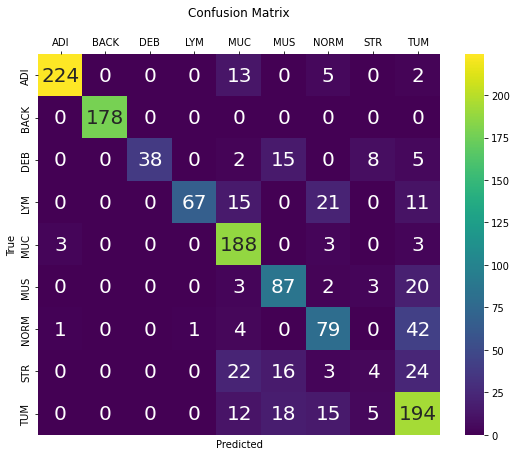

In [160]:
heat_confmatrix(cm.numpy())